#  Applying k Nearest Neighbours to classify Amazon reviews as Positive or Negative and testing the performance of this approach
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id<br>
ProductId - unique identifier for the product<br>
UserId - unqiue identifier for the user<br>
ProfileName<br>
HelpfulnessNumerator - number of users who found the review helpful<br>
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not<br>
Score - rating between 1 and 5<br>
Time - timestamp for the review<br>
Summary - brief summary of the review<br>
Text - text of the review<br>
#### Objective:
Given a review, generate its Bag-of-Words(BoW), TF-IDF, Average Word2Vec and TF-IDF weighted Word2Vec analysis models, and predict if the review is Positive or Negative by using the k Nearest Neihgbours Classification approach, both by the Brute Force and kD Tree methods.

<b>Note:<b> As a reference, the reviews are marked as Positive/Negative using the Score/Rating. A rating of 4 or 5 is considered a positive review, whereas a review of 1 or 2 is considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.
The outputs obtained after training the model on this training data, is then comppared with this reference polarity to determine the performance of our model. 

##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
#Import all necessary libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import datetime

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As we can see above, the same user has multiple reviews with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that :
<br> <br>
ProductId=B000HDOPZG was Loacker Quadratini <b>Vanilla</b> Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini <b>Lemon</b> Wafer Cookies, 8.82-Ounce Packages (Pack of 8), and so on<br>

Thus, we can see that they are the same product, but of different flavors. Hence, the rows having the same values of the parameters mentioned above were eliminated for reducing redundancy.<br>

The method used for the same is to first sort the data according to ProductId and then retain only the first product review details, while deleting the rest. For example, out of he above lines, just the review for ProductId=B000HDL1RQ is retained and others deleted. This method ensures that only one representative for each product from any given user remains.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

(364173, 10)


69.25890143662969

<b>Observation:-</b> It was also seen that in the two rows given below, the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from our calcualtions.

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing let's see the number of entries left
print(final.shape)

#How many positive and negative reviews each are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Having finished deduplication, our data still requires some preprocessing before we can go on further with analysis and visualization.
Hence in the Preprocessing phase we do the following in the given order:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'then', 'yourself', 'too', 'once', 'is', "should've", 'had', 'didn', 'there', "mightn't", 'before', 'you', "wasn't", 'on', "wouldn't", 'will', 'been', 'have', 'did', 'don', "couldn't", 'why', 'own', 'be', 'when', 'so', 'wouldn', 'should', 'now', "shan't", "won't", 'both', 'll', 'they', 'between', 'mightn', "shouldn't", "don't", 'haven', 't', 'a', 'such', 'not', 'wasn', 'ours', 'same', 're', "weren't", 'from', 'over', 'few', 'as', 'all', 'having', 'just', 'below', 'won', 'm', 'y', 'hadn', "mustn't", 'myself', 'how', "it's", "haven't", 'our', 'them', 'each', 'her', 'itself', 'the', 'for', 'these', 'being', 'weren', 'with', 'about', "doesn't", 'were', 'of', 'isn', 'was', 'after', 'or', 'here', 'those', "you'd", "hasn't", 'my', 'this', 'by', 'ourselves', 'than', 'doesn', "you've", 'what', 'only', 'again', 'because', 'and', 'hasn', 'through', 'shan', 'his', 'yourselves', 'whom', 'in', "aren't", "you'll", 'mustn', 'most', 'against', 'are', 'some', "needn't", "didn't", 'that', 'no', 'couldn'

## Code for implementing all preprocessing steps mentioned earlier
In this step, each review is stripped of its HTML tags, punctuation marks and stopwords, before storing it in an SQL LITE file.
Since these steps are applied on each of the ~400K reviews serially, it takes a while to run.

In [9]:
# This code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [10]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please execute the above cell")
print(final.head(2))

    index      Id   ProductId          UserId      ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL  shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U            Tracy   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1   939340800   
1                     1                       1      1  1194739200   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   

                                         CleanedText  
0  witti littl book make son laugh loud recit car...  
1  grew read sendak book watch realli rosi movi i...  


# Random Sampling and Time-based Slicing of the Dataset

We will be randomly sampling the dataset for 100K reviews and sorting them in increasing order of their timestamp, i.e. from the earliest to the latest.<br> After that, we are splitting the 100K datapoints into Train and Test Sets, with the first 70% being the Train and the remaining or latter 30% being the Test Set. However, to tune our KNN model and find the optimal value of k(no. of neighbors), we will again be splitting the Train Set into Train and Cross-Valiudation(CV) sets, with the initial 70%(49K rows) being the Train Set, and the remaining 30%(21K rows) the CV set.

In [11]:
data = final.sample(100000, random_state=0)
#print(data.shape)
#Convert the Timestamp values(given in seconds) in the Time column to Dates
data.Time = pd.to_datetime(data.Time, unit='s')
data.sort_values(by='Time', inplace=True)
print(data["Score"].value_counts())

1    84163
0    15837
Name: Score, dtype: int64


In [12]:
#from sklearn.cross_validation import train_test_split
train_text = data[:70000]
test_text = data[70000:]
y_train = train_text['Score']
X_train = train_text.drop(['Score'], axis=1)
y_test = test_text['Score']
X_test = test_text.drop(['Score'], axis=1)

print(X_train.shape, y_train.shape)
#print(type(y_train), type(y_test))
print(X_test.shape, y_test.shape)

# Creating the Training and Cross-Validation sets from X_train, 
# with the first 70% being Training Set and later 30% being the CV Set
X_tr = X_train.iloc[:-21000][['CleanedText']]
y_tr = y_train.iloc[:-21000]
X_cv = X_train.iloc[-21000:][['CleanedText']]
y_cv = y_train.iloc[-21000:]

(70000, 11) (70000,)
(30000, 11) (30000,)


# Bag of Words (BoW)
We are generating a Bag of Words model only from the first 100K reviews of the preprocessed and Time-sorted dataset in order to prevent too many features in the generated Bag of Words model, and reduce computation time.

In [56]:
#Creating the BoW model on the Training Set and applying it to the CV set
vec = CountVectorizer()#max_features=2500, min_df=40)
vec.fit(X_tr.CleanedText.values)
bow_train = vec.transform(X_tr.CleanedText.values)
bow_cv = vec.transform(X_cv.CleanedText.values)
print("Number of unique words in the BoW model :", bow_train.get_shape()[1])

#Using Truncated SVD to find Optimal number of dimensions to reduce the BoW models to
#Initially, it is run with one-tenth the number of actual dimensions of the Bow Train model
tsvd = TruncatedSVD(n_components= bow_train.get_shape()[1]//10)
bow_train_tsvd = tsvd.fit_transform(bow_train)

#Here, the percentage of variance explained by each component is calculated
#Then, no. of components which explain >90% variance is taken as required no. of components
per_explained_variances = np.var(bow_train_tsvd, axis=0) * 100.0/np.var(bow_train_tsvd, axis=0).sum()
cum_explained_var = np.cumsum(per_explained_variances)
n_comps = np.where(cum_explained_var>=90.0)[0][0] + 1

#Reducing the BoW models to the only the required no. of components
tsvd = TruncatedSVD(n_components = n_comps)
bow_train = tsvd.fit_transform(bow_train)
bow_cv = tsvd.transform(bow_cv)

#Standardizing the Train and CV sets
bow_train = StandardScaler().fit_transform(bow_train)
bow_cv = StandardScaler().fit_transform(bow_cv)

Number of unique words in the BoW model : 26889


<b>Observation :</b> Since there are about 27K unique words in the model, it corresponds to that many different dimensions for each datapoint. That is too many points for KNN to work efficiently on. <br>
Hence, we use the Truncated SVD(Single Value Decomposition) algorithm to reduce the dimensions to a more manageable number, initially reducing the dimensions to 2688, or one-tenth the original no. of dimensions. After applying Truncated SVD, we inspect how many dimensions are enough to explain 90% of the variance in the dataset.<br> We find that 1061 dimensions are enough, and reduce the BoW model to that many dimensions for the next steps. The cumulative percentage of variance explained as a function of the no. of dimensions is plotted below.

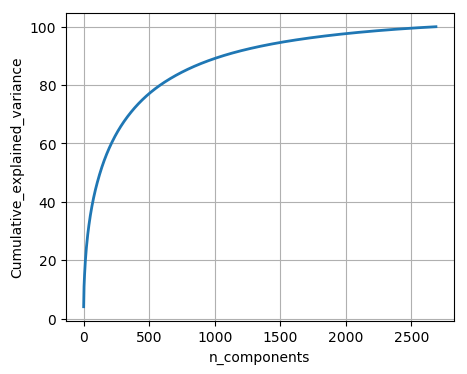

No.of components which explain 90% of the variance:  1061


In [58]:
#import matplotlib as mpl
#mpl.style.use('default')
plt.figure(1, figsize=(5, 4))
plt.clf()
plt.plot(cum_explained_var, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.grid()
plt.show()
print("No.of components which explain 90% of the variance: ", n_comps)

## Applying K Nearest Neighbors on the BoW model

Below is a function for deciding the optimal value of k by first Training the KNN algorithm on the Train Set, and then noting its performance at predicting the Review Score on the CV Set, for each given value of k. The performance if measured in terms of F1-Score and plotted vs the corresponding value of k.

In [13]:
def KNN(X, y, algo, X_cv, y_cv):
    #tscv = TimeSeriesSplit(n_splits=5)
    n_neighbors = list(filter(lambda x: x%2 != 0, np.arange(1, 50)))

    f1_scores = []
    err = []

    for k in tqdm(n_neighbors):         
        #Training the KNN Classifier on the Training Set and predicting labels on the CV set
        knn = KNeighborsClassifier(n_neighbors=k, algorithm=algo)
        knn.fit(X, y)
        pred = knn.predict(X_cv)
        
        f1_scores.append(metrics.f1_score(y_pred=pred, y_true=y_cv))
        err.append((1 - np.equal(pred, y_cv).sum()/pred.shape[0]) * 100)
    
    plt.figure(1, figsize=(12, 4))
    plt.clf()#; plt.axis('tight')
    plt.subplot(121)
    plt.plot(n_neighbors, f1_scores, linewidth=2)
    plt.xlabel("No. of Neighbors(k)")
    plt.ylabel("F1 Score on CV")
    plt.xticks([0,5,10,15,20,25])
    plt.grid(True)
    plt.subplot(122)
    plt.plot(n_neighbors, err, linewidth=2)
    plt.xlabel("No. of Neighbors(k)")
    plt.ylabel("Error on CV")
    plt.xticks([0,5,10,15,20,25])
    plt.grid(True)
    plt.show()

## Training and Cross-Validating the KNN approach on the BoW model

100%|██████████| 25/25 [15:57<00:00, 39.09s/it]


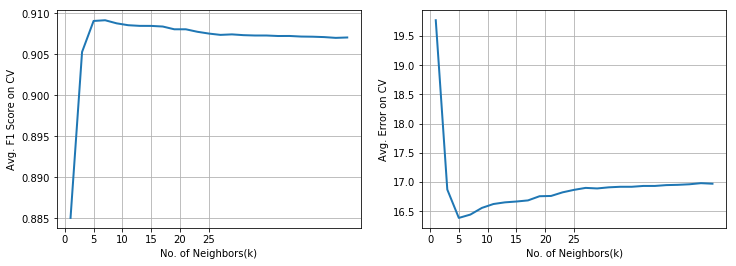

In [15]:
#print("Training KNN Classifier using Brute Force")
KNN(bow_train, y_tr, 'brute', bow_cv, y_cv)

### Using Optimal value of k to predict Scores on the Test Set
From the plots for F1 Score and Mean error, we can see that 5 seems to be an optimal value for the number of nearest neighbors to be considered while applying the KNN Classification on the Test Set.
Hence, we will be running the KNN Classifier with 5 nearest neighbors on the Test Set. We are only using the Brute Force approach here as KD Tree was taking too long to run.

In [33]:
bow_test = vec.transform(X_test.CleanedText.values)
bow_test = tsvd.fit_transform(bow_test)
bow_test_std = StandardScaler().fit_transform(bow_test)

knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
knn.fit(X=bow_train_std, y=y_tr)
pred = knn.predict(X=bow_test_std)

print("F1 Score on the Test Set :", metrics.f1_score(y_pred=pred, y_true=y_test))
print("Classification Accuracy on the Test Set:", (np.equal(pred, y_test).sum()/pred.shape[0]) * 100)

F1 Score on the Test Set : 0.8979269278835551
Classification Accuracy on the Test Set: 81.48666666666666


We get a decent F1 score of ~0.9 and an accuracy of 81.49% on the unseen data, i.e. Test Set. We can say that the running the Classifier on the past reviews has helped us get a decent prediction of the final Review score for future reviews.

# TF-IDF representation of Reviews 
We are again generating a TF-IDF representation of the only the first 100K reviews in the dataset sorted by time, and running the K-Nearest Neighbors Classification on it.

In [17]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,1))
#tf_idf_vec.fit(X_tr.CleanedText.values)
tfidf_train = tf_idf_vec.fit_transform(X_tr.CleanedText.values)
print("The number of unique words(only unigrams): in the TF-IDF model: ", tfidf_train.get_shape()[1])
tfidf_cv = tf_idf_vec.transform(X_cv.CleanedText.values)

#Using Truncated SVD to find Optimal number of dimensions to reduce the BoW models to
#Initially, it is run with one-tenth the number of actual dimensions of the Bow Train model
tsvd = TruncatedSVD(n_components= tfidf_train.get_shape()[1]//10)
tfidf_train_tsvd = tsvd.fit_transform(tfidf_train)

#Here, the percentage of variance explained by each component is calculated
#Then, no. of components which explain >90% variance is taken as required no. of components
per_explained_variances = np.var(tfidf_train_tsvd, axis=0) * 100.0/np.var(tfidf_train_tsvd, axis=0).sum()
cum_explained_var = np.cumsum(per_explained_variances)
n_comps = np.where(cum_explained_var>=90.0)[0][0] + 1

#Reducing the BoW models to the only the required no. of components
tsvd = TruncatedSVD(n_components = n_comps)
tfidf_train = tsvd.fit_transform(tfidf_train)
tfidf_cv = tsvd.transform(tfidf_cv)

#Standardizing the Train and CV sets
tfidf_train = StandardScaler().fit_transform(tfidf_train)
tfidf_cv = StandardScaler().fit_transform(tfidf_cv)

The number of unique words(only unigrams): in the TF-IDF model:  26889


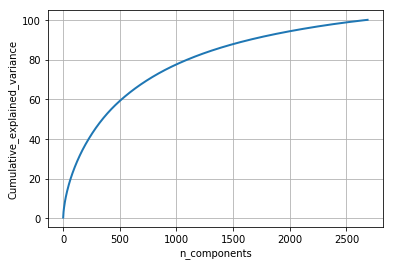

No.of components which explain 90% of the variance:  1651


In [18]:
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_explained_var, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()
print("No.of components which explain 90% of the variance: ", n_comps)

<b>Observation :</b>In case of TF-IDF, it is seen that a higher no. of dimensions(1651) are needed to explain 90% the variance in the Training Set. Hence, Truncated SVD is used to reduce the nearly the dataset from ~27K dimensions to 1651 dimensions for further processing.

## Applying K Nearest Neighbors on the TF-IDF model

### Tuning the Hyperparameters (k) using Cross-Validation

100%|██████████| 25/25 [18:16<00:00, 44.64s/it]


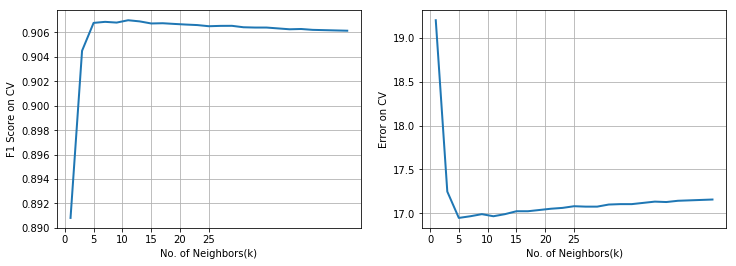

In [19]:
KNN(tfidf_train, y_tr, 'brute', tfidf_cv, y_cv)

### Using Optimal value of k to predict Scores on the Test Set

In [18]:
tfidf_test = tf_idf_vec.transform(X_test.CleanedText.values)
tfidf_test = tsvd.fit_transform(tfidf_test)
tfidf_test = StandardScaler().fit_transform(tfidf_test)

knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
knn.fit(X=tfidf_train, y=y_tr)
pred = knn.predict(X=tfidf_test)

print("F1 Score on the Test Set :", metrics.f1_score(y_pred=pred, y_true=y_test))
print("Classification Accuracy on the Test Set:", (np.equal(pred, y_test).sum()/pred.shape[0]) * 100)

F1 Score on the Test Set : 0.9021444777867232
Classification Accuracy on the Test Set: 82.17333333333333


# Word2Vec

In [21]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google, a 3.3G file,which will occupy ~9Gb once 
# loaded into memory, so please do this step only if you have >12G of RAM.
# Alternativelly, we can use the provided pickle file wich contains a dict , 
# and it contains all our corpus words as keys and  model[word] as values.
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [22]:
i=0
list_of_sent=[]
#Sort the entire preprocessed dataset by Time
final.Time = pd.to_datetime(final.Time, unit='s')
final.sort_values(by='Time', inplace=True)

for sent in final[:100000]['CleanedText'].values:
    list_of_sent.append(sent.split())

In [23]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [24]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [25]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
w2v_model.wv.most_similar('tasti')

number of words that occured minimum 5 times  12508
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


[('delici', 0.8095229864120483),
 ('yummi', 0.7529089450836182),
 ('nice', 0.6556087136268616),
 ('satisfi', 0.6474446058273315),
 ('hearti', 0.6348320841789246),
 ('tastey', 0.6290578246116638),
 ('good', 0.6071966886520386),
 ('dens', 0.6053351163864136),
 ('substanti', 0.5787638425827026),
 ('sweet', 0.5709654092788696)]

# Avg W2V
Below, we are generating an Average Word2Vec representation on the first 100K reviews of the dataset, to generate a 50-dimensional vector for each review sentence.

In [62]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(list_of_sent))
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:47<00:00, 597.37it/s]


100000
100000
50


## Applying KNN on Avg W2V

### Slicing the dataset to create Train, CV and Test sets

In [22]:
# Since the dataset is sorted by time, we are taking 1st 70% of the datapoints as the training set, and the rest as Test Set
tr_index = (int)(0.7 * len(sent_vectors))

X_tr = sent_vectors[:tr_index]
y_tr = final.iloc[:tr_index]['Score']
X_test = sent_vectors[tr_index:]
y_test = final.iloc[tr_index:100000]['Score']

# The training set is then again split into Train and CV sets,, with the latter 30% being the CV set. 
tr_index = (int)(0.7 * tr_index)
X_cv = X_tr[tr_index:]
y_cv = y_tr[tr_index:]
X_tr = X_tr[:tr_index]
y_tr = y_tr[:tr_index]
print("No. of samples in Training Set :", len(y_tr))
print("No. of samples in CV Set :", len(y_cv))
print("No. of samples in Test Set :", len(y_test))

# Standardizing the Datasets
X_tr = StandardScaler().fit_transform(X_tr)
X_cv = StandardScaler().fit_transform(X_cv)
X_test = StandardScaler().fit_transform(X_test)

No. of samples in Training Set : 49000
No. of samples in CV Set : 21000
No. of samples in Test Set : 30000


### Tuning the Hyperparameters (k) using Cross-Validation

100%|██████████| 25/25 [12:05<00:00, 28.95s/it]


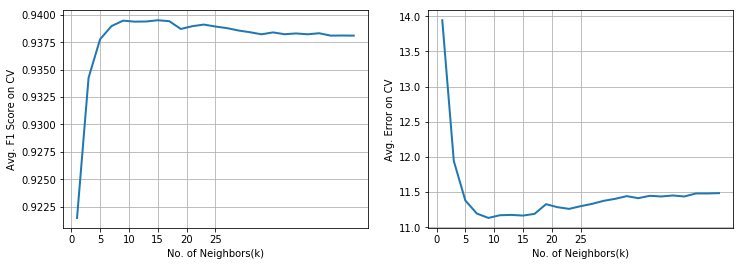

In [23]:
KNN(X_tr, y_tr, 'brute', X_cv, y_cv)

### Using Optimal value of k to predict Scores on the Test Set

In [24]:
knn = KNeighborsClassifier(n_neighbors=8, algorithm='brute')
knn.fit(X=X_tr, y=y_tr)
pred = knn.predict(X=X_test)

print("F1 Score on the Test Set :", metrics.f1_score(y_pred=pred, y_true=y_test))
print("Classification Accuracy on the Test Set:", (np.equal(pred, y_test).sum()/pred.shape[0]) * 100)

F1 Score on the Test Set : 0.935186378278877
Classification Accuracy on the Test Set: 88.26333333333334


In [26]:
knn = KNeighborsClassifier(n_neighbors=8, algorithm='kd_tree')
knn.fit(X=X_tr, y=y_tr)
pred = knn.predict(X=X_test)

print("F1 Score on the Test Set :", metrics.f1_score(y_pred=pred, y_true=y_test))
print("Classification Accuracy on the Test Set:", (np.equal(pred, y_test).sum()/pred.shape[0]) * 100)

F1 Score on the Test Set : 0.935186378278877
Classification Accuracy on the Test Set: 88.26333333333334


# TF-IDF Weighted W2V
Below, we are generating a TF-IDF Weighted Word2Vec representation on the first 100K reviews of the dataset, using the Word to Vec model generated earlier, and TF-IDF values of each word to generate a 50-dimensional vector for each review sentence.

In [27]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole corpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:49<00:00, 591.06it/s]


### Slicing the dataset to create Train, CV and Test sets

In [28]:
# Since the dataset is sorted by time, we are taking 1st 70% of the datapoints as the training set, and the rest as Test Set
tr_index = (int)(0.7 * len(tfidf_sent_vectors))

X_tr = tfidf_sent_vectors[:tr_index]
y_tr = final.iloc[:tr_index]['Score']
X_test = tfidf_sent_vectors[tr_index:]
y_test = final.iloc[tr_index:100000]['Score']

# The training set is then again split into Train and CV sets,, with the latter 30% being the CV set. 
tr_index = (int)(0.7 * tr_index)
X_cv = X_tr[tr_index:]
y_cv = y_tr[tr_index:]
X_tr = X_tr[:tr_index]
y_tr = y_tr[:tr_index]
print("No. of samples in Training Set :", len(y_tr))
print("No. of samples in CV Set :", len(y_cv))
print("No. of samples in Test Set :", len(y_test))

# Standardizing the Datasets
X_tr = StandardScaler().fit_transform(X_tr)
X_cv = StandardScaler().fit_transform(X_cv)
X_test = StandardScaler().fit_transform(X_test)

No. of samples in Training Set : 49000
No. of samples in CV Set : 21000
No. of samples in Test Set : 30000


### Tuning the Hyperparameters (k) using Cross-Validation

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:06:56<00:00, 164.71s/it]


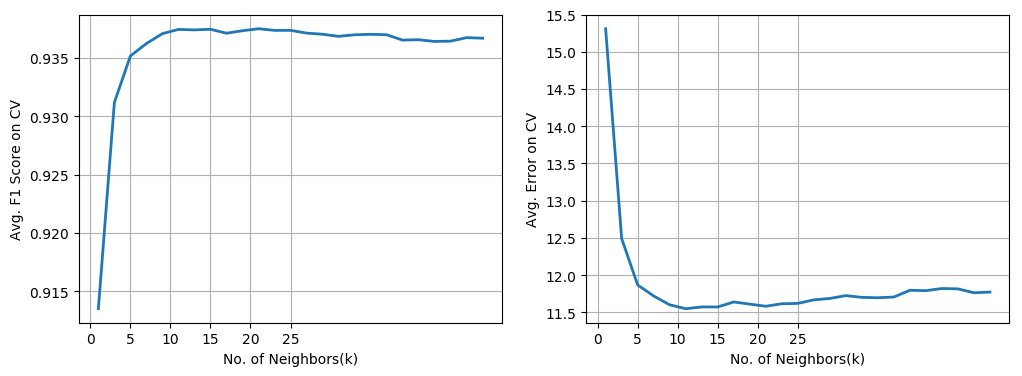

In [29]:
KNN(X_tr, y_tr, 'kd_tree', X_cv, y_cv)

### Using Optimal value of k to predict Scores on the Test Set

In [33]:
knn = KNeighborsClassifier(n_neighbors=11, algorithm='brute')
knn.fit(X=X_tr, y=y_tr)
pred = knn.predict(X=X_test)

print("F1 Score on the Test Set :", metrics.f1_score(y_pred=pred, y_true=y_test))
print("Classification Accuracy on the Test Set:", (np.equal(pred, y_test).sum()/pred.shape[0]) * 100)

F1 Score on the Test Set : 0.932005669223
Classification Accuracy on the Test Set: 87.5266666667


In [31]:
knn = KNeighborsClassifier(n_neighbors=11, algorithm='kd_tree')
knn.fit(X=X_tr, y=y_tr)
pred = knn.predict(X=X_test)

print("F1 Score on the Test Set :", metrics.f1_score(y_pred=pred, y_true=y_test))
print("Classification Accuracy on the Test Set:", (np.equal(pred, y_test).sum()/pred.shape[0]) * 100)

F1 Score on the Test Set : 0.932005669223
Classification Accuracy on the Test Set: 87.5266666667


The Average and TF-IDF weighted Word2Vec models seem to give a better performance with the KNN Classifier for prediction of Review Scores, when applied to unseen Test data which is chronologically later than the Training Set.

# Conclusion
The performance of the different Word Vectorization techniques with a KNN model has been summarised in the table below:

In [3]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter Used(Nearest neighbours)", "Test F1-Score", "Test Accuracy %"]
x.add_row(["BoW", "KNN", "5", "0.8979", "81.49"])
x.add_row(["TF-IDF", "KNN", "5", "0.9021", "82.17"])
x.add_row(["Avg-W2V", "KNN", "8", "0.9352", "88.26"])
x.add_row(["TFIDF-W2V", "KNN", "11", "0.9320", "87.53"])
print(x)

+------------+-------+-----------------------------------------+---------------+-----------------+
| Vectorizer | Model | Hyperparameter Used(Nearest neighbours) | Test F1-Score | Test Accuracy % |
+------------+-------+-----------------------------------------+---------------+-----------------+
|    BoW     |  KNN  |                    5                    |     0.8979    |      81.49      |
|   TF-IDF   |  KNN  |                    5                    |     0.9021    |      82.17      |
|  Avg-W2V   |  KNN  |                    8                    |     0.9352    |      88.26      |
| TFIDF-W2V  |  KNN  |                    11                   |     0.9320    |      87.53      |
+------------+-------+-----------------------------------------+---------------+-----------------+


**The KNN model with 8 nearest neighbours seems to perform best when used with the Average-Word2Vec vectorized dataset.**